In [2]:
%matplotlib notebook
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from astropy.io import fits
from astropy import wcs
import imgscl
# from scipy.misc import bytescale
import pandas as pd
import glob, os, copy
from scipy import ndimage
from skimage.feature import register_translation
from scipy.ndimage import fourier_shift
import init_cfg as ic

In [3]:
# ----- Loading the original HST image ----- #

# kpc20 = 20.0/4.370/0.03
ifu_h = 5.0 / 0.05
ifu_w = 7.0 / 0.05
# seeing = 0.7 / 0.05

# ----- Directories ----- #
dir_fig = ic.cpath+"diagram/linefits/"
if (glob.glob(dir_fig) == []):
    os.system("mkdir "+dir_fig)
diI = "/data/jlee/DATA/HLA/McPartland+16/MACS0916/JFG1/Phot/"
diG = ic.dir_redux


# ----- Reading FITS file ----- #
hdr1 = fits.getheader(ic.cube_list[0], ext=0)
gra, gdec, gpa = hdr1['RA'], hdr1['DEC'], hdr1['PA']
print(gpa)


# ----- Reading FITS images and creating RGB data ----- #
img606 = fits.getdata(diI+'606_ori.fits', ext=0)
img814 = fits.getdata(diI+'814_ori.fits', ext=0)

cimg = np.zeros((img814.shape[0], img814.shape[1], 3), dtype=float)
cimg[:,:,0] = imgscl.linear(0.5*img814, scale_min=-0.02, scale_max=0.075)   # R
cimg[:,:,1] = imgscl.linear(0.5*(img606+img814), scale_min=-0.02, scale_max=0.15)   # G
cimg[:,:,2] = imgscl.linear(0.5*img606, scale_min=-0.02, scale_max=0.075)   # B


# ----- WCS to XY ----- #
h = fits.getheader(diI+'606_ori.fits', ext=0)
w = wcs.WCS(h)
px, py = w.wcs_world2pix(gra, gdec, 1)

10.0


In [4]:
# # ----- Reading ellipse region file ----- #
# from reg_saoimage import read_region
# regionfile = "HST_boundary_1sig.reg"
# x0, y0, a, b, pa = read_region(regionfile, regtype='ellipse')
# x0, y0, a, b, pa = x0[0], y0[0], a[0], b[0], pa[0]

# from matplotlib.patches import Ellipse as ell

<IPython.core.display.Javascript object>


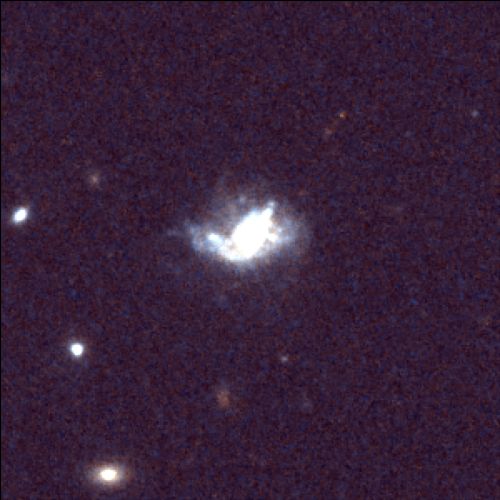

(300, 300, 3)

In [5]:
# ----- Loading the original HST image ----- #

# ----- Figure 1 ----- #
fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.set_position([0.0,0.0,1.0,1.0])
ax1.tick_params(labelleft=False)
ax1.tick_params(labelbottom=False)
plt.tick_params(width=0.0, length=0.0)
# -------------------- #

# Color map
rth = 150.0
img = cimg[int(np.round(py)-1-rth):int(np.round(py)-1+rth),
           int(np.round(px)-1-rth):int(np.round(px)-1+rth),:]

ax1.imshow(img, aspect='equal', origin='lower')

# x1, y1 = x0-(int(np.round(px)-rth)), y0-(int(np.round(py)-rth))
# e1 = ell((x1, y1), width=2*a, height=2*b, angle=pa,
#          fill=False, color='red', linestyle='-', linewidth=1.25)
# ax1.add_patch(e1)

img.shape

In [6]:
# ----- Rotating the image ----- #
rotated_img = ndimage.rotate(img, gpa)
rotated_img.shape

(348, 348, 3)

<IPython.core.display.Javascript object>


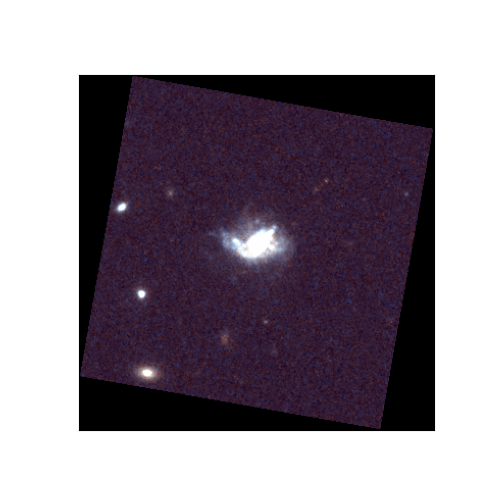

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [7]:
# ----- Showing the rotated image ----- #

# ----- Figure 2 ----- #
fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.set_position([0.0,0.0,1.0,1.0])
ax1.tick_params(labelleft=False)
ax1.tick_params(labelbottom=False)
plt.tick_params(width=0.0, length=0.0)
# -------------------- #
ax1.imshow(rotated_img, aspect='equal', origin='lower')

# t1 = np.arctan(y1/x1)*180./np.pi
# d1 = np.sqrt(x1**2 + y1**2)

# if ((gpa >= 0.) & (gpa < 90.)):
#     x2_0 = 0.
#     y2_0 = img.shape[0]*np.sin(gpa*np.pi/180.)
# if ((gpa >= 90.) & (gpa < 180.)):
#     x2_0 = -img.shape[0]*np.cos(gpa*np.pi/180.)
#     y2_0 = -img.shape[0]*(np.sin(gpa*np.pi/180.)+np.cos(gpa*np.pi/180.))
# if ((gpa >= 180.) & (gpa < 270.)):
#     x2_0 = -img.shape[0]*(np.sin(gpa*np.pi/180.)+np.cos(gpa*np.pi/180.))
#     y2_0 = -img.shape[0]*np.sin(gpa*np.pi/180.)
# if ((gpa >= 270.) & (gpa < 360.)):
#     x2_0 = img.shape[0]*np.cos(gpa*np.pi/180.)
#     y2_0 = 0.
# x2 = x2_0 + d1*np.cos((t1-gpa)*np.pi/180.) 
# y2 = y2_0 + d1*np.sin((t1-gpa)*np.pi/180.)

# pa2 = pa-gpa

# e2 = ell((x2, y2),
#          width=2*a, height=2*b, angle=pa2,
#          fill=False, color='red', linestyle='-', linewidth=1.25)
# ax1.add_patch(e2)

plt.tight_layout()

In [8]:
# ----- Background values ----- #
m0, m1, m2 = np.nanmean(img[260:380, 250:370], axis=(0,1))
s0, s1, s2 = np.std(img[260:380, 250:370], axis=(0,1))
print(m0, m1, m2)
print(s0, s1, s2)

0.19828847938344532 0.10773478848544354 0.20502640527471688
0.03512025311272094 0.025979478429032275 0.030544138386658582


In [9]:
# ----- Putting pixel values to no-signal pixels ----- #
rimg = copy.deepcopy(rotated_img)
no_sign = (rimg == [0., 0., 0.])
no_sign_idx = np.argwhere(no_sign)

for i in np.arange(no_sign_idx.shape[0]):
    rimg[no_sign_idx[i,0], no_sign_idx[i,1], :] = np.random.normal([m0, m1, m2], [s0, s1, s2])

rimg.shape

(348, 348, 3)

<IPython.core.display.Javascript object>


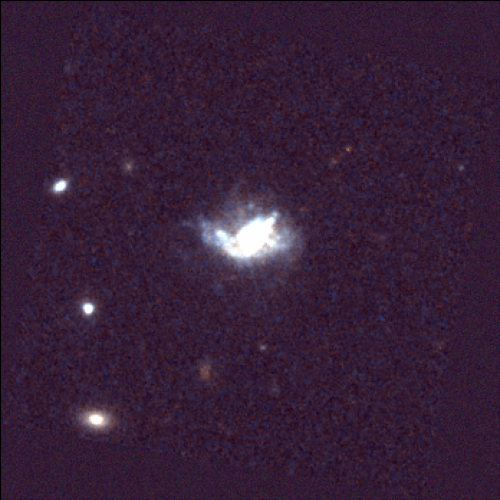

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [10]:
# ----- Showing the created image ----- #

# ----- Figure 3 ----- #
fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.set_position([0.0,0.0,1.0,1.0])
ax1.tick_params(labelleft=False)
ax1.tick_params(labelbottom=False)
plt.tick_params(width=0.0, length=0.0)
# -------------------- #
ax1.imshow(rimg, aspect='equal', origin='lower')

# e2 = ell((x2, y2),
#          width=2*a, height=2*b, angle=pa2,
#          fill=False, color='red', linestyle='-', linewidth=1.25)
# ax1.add_patch(e2)

# plt.tight_layout()

In [11]:
# ----- Reading H alpha flux map ----- #
dir_Ha = ic.cpath+'lines3/Halpha/'
fits.open(dir_Ha+'flux_2D.fits').info()

Ha_flx = fits.getdata(dir_Ha+'flux_2D.fits', ext=0)
Ha_flx.shape
Ha_snr = fits.getdata(dir_Ha+'snr_2D.fits', ext=0)
Ha_sig = fits.getdata(dir_Ha+'sigma_2D.fits', ext=0)
Ha_rchisq = fits.getdata(dir_Ha+'rchisq_2D.fits', ext=0)

# snr_cnd = (Ha_snr < 3.0)
# # sig_cnd = (Ha_sig < lsig_llim)
# rchi25, rchi50, rchi75 = np.percentile(Ha_rchisq[Ha_rchisq > 0.], [25.0, 50.0, 75.0])
# rchisq_cnd = (Ha_rchisq >= rchi50)
# flx25, flx50, flx75 = np.percentile(Ha_flx[Ha_flx > 0.], [25.0, 50.0, 75.0])
# flx_cnd = (Ha_flx <= flx50)
# zero_cnd = (snr_cnd | rchisq_cnd | flx_cnd)
# Ha_flx[zero_cnd] = 0.

Filename: /data/jlee/DATA/Gemini/Programs/GS-2019A-Q-214/analysis2/lines3/Halpha/flux_2D.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   (68, 49)   float64   


In [12]:
# ----- Making cutout image for 2x2 binning ----- #
hstimg = rimg[int(0.5*(rimg.shape[0]-1)-Ha_flx.shape[0]):int(0.5*(rimg.shape[0]-1)+Ha_flx.shape[0]),
              int(0.5*(rimg.shape[1]-1)-Ha_flx.shape[1]):int(0.5*(rimg.shape[1]-1)+Ha_flx.shape[1]), :]
hstimg.shape

(98, 136, 3)

<IPython.core.display.Javascript object>


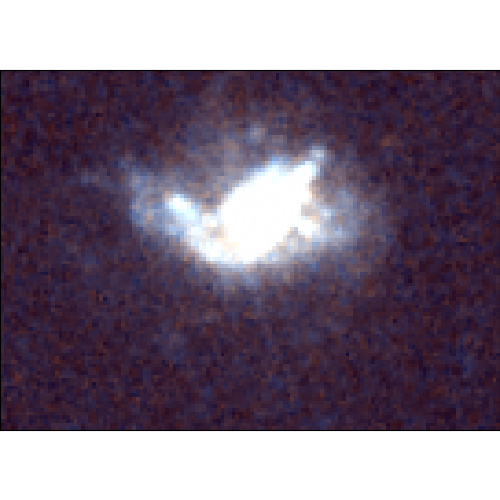

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [13]:
# ----- Showing the cutout HST image ----- #

# ----- Figure 4 ----- #
fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.set_position([0.0,0.0,1.0,1.0])
ax1.tick_params(labelleft=False)
ax1.tick_params(labelbottom=False)
plt.tick_params(width=0.0, length=0.0)
# -------------------- #
ax1.imshow(hstimg, aspect='equal', origin='lower')

# x3 = x2-(int(0.5*(rimg.shape[1]-1)-Ha_flx.shape[1]))
# y3 = y2-(int(0.5*(rimg.shape[0]-1)-Ha_flx.shape[0]))
# pa3 = pa2
# e3 = ell((x3, y3),
#          width=2*a, height=2*b, angle=pa3,
#          fill=False, color='red', linestyle='-', linewidth=1.25)
# ax1.add_patch(e3)

# plt.tight_layout()

In [14]:
# ----- 2x2 binning ----- #
bin_nx, bin_ny = 2, 2

hstimg_binned = np.zeros((int(hstimg.shape[0]/bin_ny), int(hstimg.shape[1]/bin_nx), hstimg.shape[2]))

for y in np.arange(int(hstimg.shape[0]/bin_ny)):
    for x in np.arange(int(hstimg.shape[1]/bin_nx)):
        hstimg_binned[y, x, :] = np.mean(hstimg[bin_ny*y:bin_ny*(y+1), bin_nx*x:bin_nx*(x+1), :], axis=(0,1))

hstimg_binned.shape

(49, 68, 3)

<IPython.core.display.Javascript object>


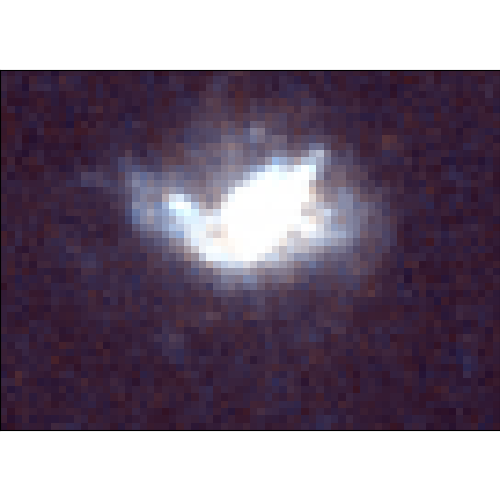

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [15]:
# ----- Showing the binned image ----- #

# ----- Figure 5 ----- #
fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.set_position([0.0,0.0,1.0,1.0])
ax1.tick_params(labelleft=False)
ax1.tick_params(labelbottom=False)
plt.tick_params(width=0.0, length=0.0)
# -------------------- #
plt.imshow(hstimg_binned, aspect='equal', origin='lower')

# x4 = x3 // 2 
# y4 = y3 // 2
# pa4 = pa3
# e4 = ell((x4, y4),
#          width=a, height=b, angle=pa4,
#          fill=False, color='red', linestyle='-', linewidth=1.25)
# ax1.add_patch(e4)

In [16]:
# ----- Making the 2D image ----- #
hstimg_2D = np.sum(hstimg_binned, axis=2)
hstimg_2D.shape

(49, 68)

<IPython.core.display.Javascript object>


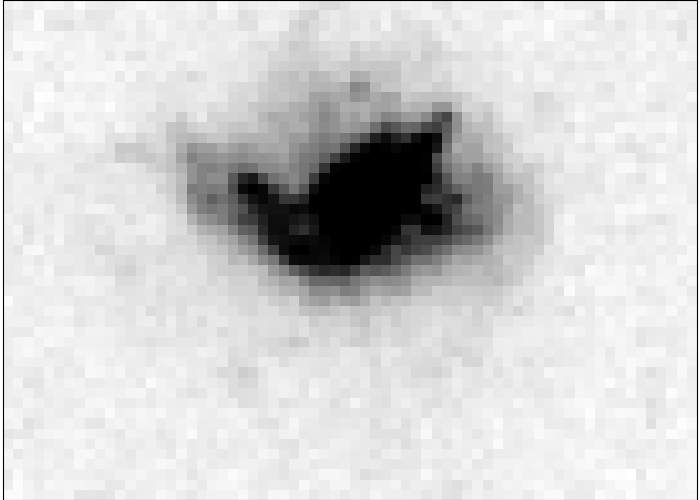

In [17]:
# ----- Showing the binned image ----- #

# ----- Figure 6 ----- #
fig1, ax1 = plt.subplots(figsize=(7,5))
ax1.set_position([0.0,0.0,1.0,1.0])
ax1.tick_params(labelleft=False)
ax1.tick_params(labelbottom=False)
plt.tick_params(width=0.0, length=0.0)
# -------------------- #
plt.imshow(hstimg_2D, aspect='equal', cmap='gray_r', origin='lower')

# e4 = ell((x4, y4),
#          width=a, height=b, angle=pa4,
#          fill=False, color='red', linestyle='-', linewidth=1.25)
# ax1.add_patch(e4)

<IPython.core.display.Javascript object>


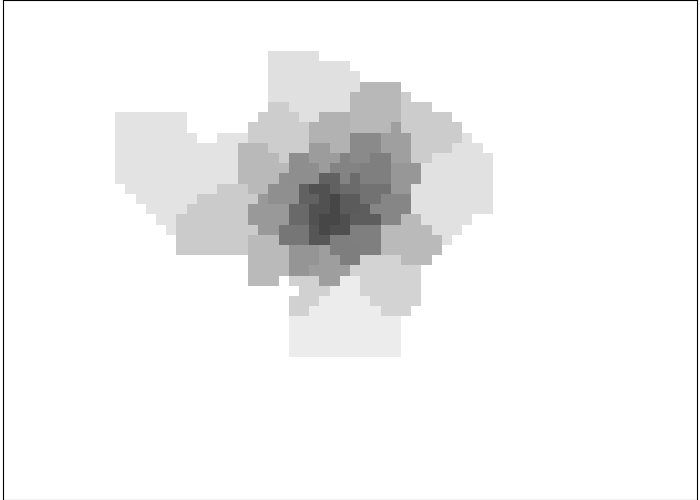

In [18]:
# ----- Showing the flux map ----- #

# ----- Figure 6 ----- #
fig1, ax1 = plt.subplots(figsize=(7,5))
ax1.set_position([0.0,0.0,1.0,1.0])
ax1.tick_params(labelleft=False)
ax1.tick_params(labelbottom=False)
plt.tick_params(width=0.0, length=0.0)
# -------------------- #
plt.imshow(np.flip(Ha_flx, axis=0), aspect='equal', cmap='gray_r', origin='lower', vmin=0.0, vmax=0.02)

# e4 = ell((x4, y4),
#          width=a, height=b, angle=pa4,
#          fill=False, color='red', linestyle='-', linewidth=1.25)
# ax1.add_patch(e4)

In [19]:
# ----- Running the 2D correlation ----- #
shifted, error, diffphase = register_translation(np.flip(Ha_flx, axis=0), hstimg_2D, 100)
corr_hstimg_binned = ndimage.shift(hstimg_binned, shift=(shifted[0], shifted[1], 0), mode='nearest')
shifted

/home/jlee/anaconda3/lib/python3.7/site-packages/skimage/feature/__init__.py:45: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')


array([ 0.41, -2.88])

In [20]:
hstimg_binned.shape

(49, 68, 3)

<IPython.core.display.Javascript object>


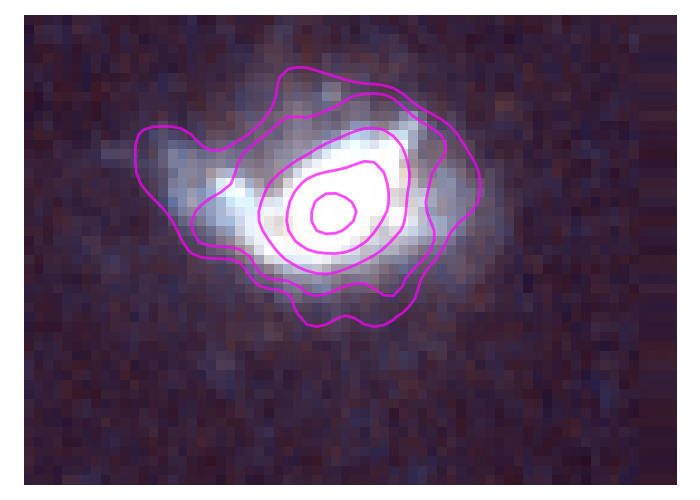

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [21]:
# ----- Figure 1 ----- #
fig1 = plt.figure(figsize=(7,5))
ax1 = plt.subplot(1, 1, 1, adjustable='box')
# ax2 = plt.subplot(2, 1, 2, adjustable='box')

ax1.imshow(corr_hstimg_binned, aspect='equal', origin='lower')
ax1.set_axis_off()

flx_data = copy.deepcopy(Ha_flx)
# flx_data[:, :20] = 0.0
sflx = ndimage.gaussian_filter(flx_data, sigma=(1.25,1.25), order=0)

sig = np.std(sflx[sflx > 0.])
levels = [0.5*sig, 1.*sig, 2.*sig, 3.*sig, 4.*sig]
lws = tuple(np.repeat(2.0, len(levels)-1)) ; cs = tuple(['magenta']*(len(levels)-1))

Y_coord = np.arange(corr_hstimg_binned.shape[0], step=1)
X_coord = np.arange(corr_hstimg_binned.shape[1], step=1)

ax1.contour(X_coord, Y_coord[::-1], sflx, levels=levels, linewidths=lws, colors=cs, alpha=0.7)
# ax2.set_axis_off()

# ax2.imshow(Ha_flx, aspect='equal', vmin=v_low, vmax=v_high, cmap='gray_r', origin='lower')
# ax2.set_axis_off()

# x5, y5, pa5 = x4+shifted[1], y4+shifted[0], pa4
# e5 = ell((x5, y5),
#          width=a, height=b, angle=pa5,
#          fill=False, color='red', linestyle='-', linewidth=1.25)
# ax1.add_patch(e5)

plt.tight_layout()